<a id="motivation"></a>
# Motivation: Can neural networks be used for time series modelig?


## But why?

There can be several reasons for using neural models for time series prediction:
- We assume, that beside the trend and periodic signals there are other patterns that we could try to extract and use (think about the "residuals" in case of decomposition)
- We don't want to do manual feature engineering, looking for wavelets, etc. we are more into end-to-end learning
- There is a Hungarian proverb: "Whoever has a hammer, sees nails everywhere." :-P

## First step: Feedforward networks for time series

Let us get back to the Airline Passengers dataset from the Time Series class for illustration.

**Source: [Monthly Airline Passenger Numbers (in thousands) 1949-1960](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)**

(Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. 
Third Edition. Holden-Day. Series G.)


Direct  link [here](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv)


In [ ]:
import numpy as np
import pandas as pd

import blaze as bz

import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/AirPassengers.csv

In [4]:
df = pd.read_csv("AirPassengers.csv",header=0)

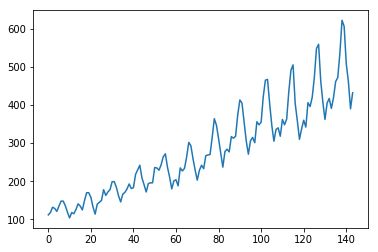

In [7]:
df["#Passengers"].plot();

### Preparing the data

If we would like to work with a feedforward network, we have to make the data acceptable for a model with a fixed input width (in this case "length", in time).

The most widespread solution for this is to use a *"sliding window"*, where we transform the data so as to create for each time point (considered as $y$) a fixed $x$ - with `window_size`, so we get a dataframe with row number: timesteps minus window size and columns and window size columns as $x$, and a vector with timsteps minus window size length as $y$ value.

|   Step     | Variable | Dimension  |  Variable | Dimension |
|:------------- |:------------| :----- |:-------------|:-----|
|**in**| df|**[data_length, 1]**|window_size| **[scalar]**|
|**out**| x|**[data_length-window_size, window_size]** |y| **[data_length-window_size, 1]** |

In this case we use a sliding window of 10, though 13-14 could also be interesting (if we think back to the PACF analysis of this data). The majority of "signal" is persumed to lie inside the ~10 months range.

We will fit a tiny two layered NN on the data with L1 regularization and Adamm optimizer.


|   Paremeter     | Value | 
|:------------- |:------------| 
|n_hidden_1 | 17 |
| n_hidden_2 | 9 |
| n_input | 10 (window_size) | 
|training_epochs | 100000|
|Optimizer| Adamm|
|learning_rate | 0.01|
|Regularizer| L1|
| l1_lambda |0.00015|


### Let's see the code!

#### Preparing the data

In [3]:
#Shameless copy of https://stackoverflow.com/questions/27852343/split-python-sequence-time-series-array-into-subsequences-with-overlap 

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window_size = 10


rolled_data = rolling_window(df["#Passengers"].values, window_size+1)

rolled_train_data, rolled_test_data = train_test_split(rolled_data, test_size=0.1, shuffle=False)

rolled_train_y = rolled_train_data[:,window_size]
rolled_train_x = rolled_train_data[:,:window_size]

rolled_test_y = rolled_test_data[:,window_size]
rolled_test_x = rolled_test_data[:,:window_size]


Let us ensure that the dimensions are ok!

In [4]:
print(rolled_test_x.shape)
print(rolled_test_y.shape)

(14, 10)
(14,)


#### Model fit

In [5]:
%%time
# Jupyter magic for measuring runtime of the cell, worth using!

# Network Parameters
n_hidden_1 = 17 # 1st layer number of features
n_hidden_2 = 9 # 2nd layer number of features
n_input = window_size 
training_epochs = 100000
learning_rate = 0.01
l1_lambda = 0.00015

# Always good practide to clean up debris from the graphs
tf.reset_default_graph()
# And set random seed for reproducibility
tf.set_random_seed(12233344556)

# Inputs
X = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 1]) # will be regression

# Network weights and biases to be trained
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, 1]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([1]))
}

#Two layer neural network with ReLU activations
layer_1 = tf.add(tf.matmul(X, weights['h1']), biases['b1'])
layer_1 = tf.nn.relu(layer_1)

layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
layer_2 = tf.nn.relu(layer_2)

# Linear output layer
out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

# Preventing overfitting by using a basic L1 regularizer
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=l1_lambda, scope=None)
# Fetching weights
weights = tf.trainable_variables() # all vars of your graph
#Calculating L1 penaly
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

# Mean squared error is a standard one, though outliers can hurt it, in such cases logcosh can be useful
cost = tf.losses.mean_squared_error(y,out_layer)+regularization_penalty

# Using Adamm for robust convergence
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#Never forget... to initialize...
init = tf.global_variables_initializer()

# Initialize TF session, use it as default context (will disappear after indent ends)
with tf.Session() as sess:
    
    # Run the initializer op
    sess.run(init)

    # Main training cycle, "full GD", one "epoch" is the whole ""huge"" dataset  
    for epoch in range(training_epochs):
        
        avg_cost = 0.
        
        # Do the training
        _, c, out_layer_result_train = sess.run([optimizer, cost, out_layer], feed_dict={X: rolled_train_x, y: np.expand_dims(rolled_train_y, axis=1)})
      
        # Display logs per every 5000 epoch step
        if epoch % 5000 == 0:
            
            # Do the validation run
            out_layer_result_test, c_test = sess.run([out_layer,cost], feed_dict={X: rolled_test_x, y: np.expand_dims(rolled_test_y, axis=1)})
            
            overfit = c_test-c

            print("Epoch:", '%04d' % (epoch+1), " train cost=", "{:.3f}".format(c),  " test cost=", "{:.3f}".format(c_test),  " overfit=", "{:.3f}".format(overfit))
            
    print("Optimization Finished!")


Epoch: 0001  train cost= 7183987.500  test cost= 9117260.000  overfit= 1933272.500
Epoch: 5001  train cost= 289.883  test cost= 1363.207  overfit= 1073.324
Epoch: 10001  train cost= 137.152  test cost= 961.873  overfit= 824.721
Epoch: 15001  train cost= 93.068  test cost= 705.474  overfit= 612.406
Epoch: 20001  train cost= 77.009  test cost= 790.625  overfit= 713.616
Epoch: 25001  train cost= 160.139  test cost= 754.649  overfit= 594.510
Epoch: 30001  train cost= 80.231  test cost= 964.559  overfit= 884.328
Epoch: 35001  train cost= 93.763  test cost= 525.269  overfit= 431.506
Epoch: 40001  train cost= 71.932  test cost= 479.388  overfit= 407.456
Epoch: 45001  train cost= 72.894  test cost= 566.959  overfit= 494.065
Epoch: 50001  train cost= 58.885  test cost= 490.242  overfit= 431.358
Epoch: 55001  train cost= 49.035  test cost= 338.017  overfit= 288.982
Epoch: 60001  train cost= 37.172  test cost= 404.465  overfit= 367.293
Epoch: 65001  train cost= 35.855  test cost= 345.891  overfit

### And let's check the result!

/home/alatus/anaconda3/envs/10_days_AI/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


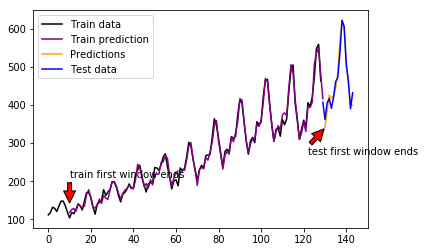

In [9]:
train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)
out_layer_result_train = pd.Series(out_layer_result_train.flatten())
out_layer_result_test = pd.Series(out_layer_result_test.flatten())

idx = train_data.index[10:]
idx = list(idx)
idx.append(train_data.index[-1]+1)

# Don't ask why this index shit is necessary :-(

out_layer_result_train.index = pd.Index(idx)

out_layer_result_test.index =test_data.index[1:] 


plt.close()
plt.plot(train_data["#Passengers"], label="Train data", color="black")
plt.plot(out_layer_result_train, label="Train prediction", color="purple")
plt.plot(out_layer_result_test, label="Predictions", color="orange")
plt.plot(test_data["#Passengers"], label="Test data", color="blue")

ax = plt.axes()
ax.annotate('train first window ends', xy=(10, 140), xytext=(10, 210),
            arrowprops=dict(facecolor='red', shrink=0.05),)
ax.annotate('test first window ends', xy=(130, 340), xytext=(122, 270),
            arrowprops=dict(facecolor='red', shrink=0.05),)

plt.legend()
plt.show()

On this absurdly small dataset and a ridiculously small NN we reached quite a nice result!

But what if we look into more complex data?

<a id="basicrnn"></a>
# Basic recurrence 


## Recurrent neural networks

### Motivation

Our unquestioned assumption (that even caused some headache in the prior data preparation case) is that for every neural model the dimensionality of the input has to be fixed, or only small deviations were allowed (for example in ConvNets we could use some padding, but not too much).

What if my data is not of uniform length, dynamically sized - for example because it comes from a (time) series of non-fixed or unknown length?

Or as an alternative formulation of this: From  prior knowledge we know, that just as in case of ConvNets for spatial invariance, we have a time series, that implies that has a temporal structure we would like to learn.

As defined before, we interpret our data as time series in the form of $\{x_{t_0}, x_{t_1}, x_{t_2} ... x_{t_n}\}$.

### Structure of recurrent networks - "classic" or "vanilla" RNN

We would like to define a neural network architecture, that in case of an input data point  $x_{t}$ can take into account the effect of prior datapoints without providing those as explicit inputs (as in the feedforward case), but as **(hidden) state**, using the activations of the NN itslef.

Till this point we only used the activation for backpropagation, but now we'll use it also for something else.

**Basic idea:**

<img src="https://cdn-images-1.medium.com/max/1400/1*lQ4izz9ZbhKYD8NClZpsmQ.png">

As a naive solution we could store the activations at $x_{t_-1}$ for all neurons and use a common $\lambda$ "dampening factor" before adding them to the activations arising at $x_{t}$

$$ f(x_t) = \sigma(w x_t +\lambda a_{t-1} + b)$$ 

This is not a complete recurrent network, but something along that direction (it's worth trying whether it works :-)

But if we have a complete neural architecture with weight matrices, why shouldn't we do this in a more clever way?

### Elman network

The first real recurrent network:

[Elman 1990](https://crl.ucsd.edu/~elman/Papers/fsit.pdf): 
Jeffrey L. Elman: Finding structure in time, Cognitive Science 14, p179-p211
<img src="https://cdn-images-1.medium.com/max/1400/1*E6OMkLY8vbPdJ7b5R27FQA.jpeg">

**The general notation for recurrent networks:**

**$$h_t=\sigma(Wx_t+Uh_{t-1})$$**

"Legend":

|Symbol| Meaning|
|:---|:---|
|$h_t$| "hidden state" at time $t$ |
|$\sigma$| activation function (typically sigmoid or tanh)|
|$x_t$| input at time $t$ |
|$W$| input to hidden weigth matrix|
|$U$| hidden to hidden weigth matrix|
|$h_{t-1}$| "hidden state" at time $t-1$ |


**In this model we learn two weigth matrices $W$ and $U$.**

Summary  [here](https://medium.com/lingvo-masino/introduction-to-recurrent-neural-network-d77a3fe2c56c).

### Small sidenote: Echo state networks

We take a randomly initialized neural system which may _not_ be ordered in layer structures. Inputs just "perturb" the inner state of these networks, we leave some "settle time" for it to get to a stable state, and use a learned one layer feedforward network to generate predictions (maybe with some "skip" connections from the input).

<img src="http://www.simbrain.net/Documentation/docs/Images/ESNDiagram.png" heigth=500 width=500>

As a metaphor we can understand that this method has some resemblance to decomposition methods, since it builds up a kind of **"reservoir"** of oscillators (hence the alternative name "reservoir computing"), and the last layer learns only a weighting scheme over the decomposition produced by the oscillators.

Formally the idea was never disproven to work, but the tuning of "settle time", or even more the fact that it was extremely hard to ensure that a diverse and stable set of oscillators are formed during random initialization made it unpopular (though much effort has been invested in solving these issues without a simple and general solution).

The method has some deep connections with [Bolzmann machines](https://en.wikipedia.org/wiki/Boltzmann_machine), but those are out of scope for this training.

Interestingly ESN-s were nearly forgotten, but in 2017 they have found their way into some interesting physics applications modeling chaotic processes like [this](https://arxiv.org/abs/1710.07313).

## Backpropagation through time (BPTT)

Question: How can we teach recurrent neural networks?

Luckily enough, the gradient based methods we have learned are appropriate for this - only with a slight modification.

### "Unrolling"

In order to understand the gradient calculation of recurrent nets we can imagine RNN-s as deep feedforward neural nets "unrolled" in time.

<img src="https://cdn-images-1.medium.com/max/1400/1*icP_8Q-I87k4Nyq0vdSl8A.png">

This is all the more useful, since traditionally we implement RNN-s in this "unrolled" way. Nowdays this is not necessarily true, or at least depends on the framework we utilize for training, since some of them solves it with iterations.

In the "unrolled" network $U$ and $W$ parameters are the same, so we can understand this as a form of "weight sharing", just as in case of ConvNets, but not through space, but through time.

Sensible description [here](https://machinelearningmastery.com/gentle-introduction-backpropagation-time/).

### Problems with this approach

In default case we calculate through the whole unrolled network for each and every timestep.

This has quite serious implications:
1. We have to "see" the whole data at once (very "un-streaming like")
2. The number of calculated gradients - thus the amount of calculation - rises exponentially with the length of the dataset. This easily makes training intractable.

<a id="vanish"></a>
# Exploding and vanishing gradients

(The hard problems)

<img src="http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt-with-gradients.png" height=400 width=400>

But the exploding computational need is just only one part of the problems with RNNs. Since they are extremely deep (in temporal sense) the gradient flow being propagated backward **"vanishes"** most of the time. In practice it results in the effect of signals far away in the past to disappear, as well as for convergence to grind to a halt.

The flipside of this is the effect of **exploding gradients** where the gradient signal gets multiplied while moving backwards in time, getting practically infinite.

These problems in practice are the same as in case of very deep feedforward networks.

A good description can be found [here](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)

### Suggested solutions

#### Careful initialization

Multiple scholars, amongst them one of Hinton's famous collaborators Quoc Le suggested a solution for RNN-s composed of ReLU nodes whereby we inicialize the $U$ matrix with a scaled version of the identity matrix.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a4218ab6975ad1809415aa168ab6371b91bafc" heigth=300 width=300>

Details can be found [here](https://arxiv.org/abs/1504.00941)

#### Gradient clipping

As the name implies, it is a procedure whereby we artificially limit, "clip" the gradients during backprop. This is kind of  a"brute force" and semi-effective solution.

<img src="http://drive.google.com/uc?export=view&id=1jK47FvUp7TcUlB2hC4rWDXoxfQNrqhRr" heigth=300 width=300>

[Pascanu and Mikolov 2012](https://arxiv.org/pdf/1211.5063.pdf)


#### Teacher forcing

Originally, the concept was to let the hidden state of the network "travel" in time, so that during the learning procedure the network can learn to memorize relevant data. In practice, if we always feed back the prediction of the network to itself, it can "drift away" from target.

Here is where teacher forcing comes in:

"Teacher forcing works by using the **actual or expected output from the training dataset** at the current time step $y_t$ as input in the next time step $X_{t+1}$, **rather than the output generated by the network $\hat{y_t}$**."

<img src="http://cnyah.com/2017/11/01/professor-forcing/non-teacher-teacher-forcing.png" width=45%>

Though in practice this makes convergence easier, but as a tradeoff it also limits the usage of memory capacity. It can work well with unbounded memory capacity models (see later).

For it to work it is necessary for the data to be defined in each step.

It can be considered a move away from the Recursive Multi-step Forecast strategy.

A good walkthrough of teacher forcing can be found [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).

#### Truncated BPTT

The main idea of this approach is that we should not be so fanaticly following signals back into the past, we can do $k1$ steps of forward passes, then do backprop only for the last $k2$ steps back in time, that is:
- We show $k1$ steps for the network
- We unroll the net and calculate $k2$ steps back and aggregate gradients
- We roll up the net and update weigths

**Two parameters:**
- $k1$ decides how many forward passes happen between backprops (kind of "batch size") and influences the speed of training (as well as many other factors, **for the newest research in regard to batch size see: [Smith, Kindermans, Ying and Lee 2017](https://arxiv.org/abs/1711.00489)**
- $k2$ influences the temporal depth of backprop. If too small, our "window" will not contain all relevant timesteps, if too big, gradients can vanish.

A nice summary again [here](https://machinelearningmastery.com/gentle-introduction-backpropagation-time/).

**Notice, that we could not effectively get rid of those ugly windows!!**

If someone would like to analyse a TensorFlow RNN implementation in detail, it can be done [here](https://www.kdnuggets.com/2017/04/build-recurrent-neural-network-tensorflow.html).

##### Fair warning:

Though BPTT would be a theoretically more sound solution, practically it is quite unfeasible. And event he truncated version is implemented sometimes in really strange ways, eg. not letting you control over $k1$ and $k2$ separately, so in practice, much of the potential of LSTM-s may get "sabotaged".

For example you can read about the struggles with Truncated BPTT in Keras [here](https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/). 


#### Anticipated Reweighted Backpropagation through time (ARTBP)

As we might have guessed, the Truncated BPTT approach gives no chance for gradients to flow from the really distant past - outside of the truncation window, so we have to come up with something.

A recent approach is **Anticipated Reweighted Backpropagation through time**

<img src="http://drive.google.com/uc?export=view&id=1AAS4b6-T1Cxl3l_U2DNpDcoUBa4z7jLJ" heigth=900 width=900>

"Like truncated BPTT, ARTBP splits the initial sequence into subsequences, and only performs backpropagation through time on subsequences. However, contrary to the latter, it **does not split the sequence evenly**. The length of each subsequence is sampled according to a specific probability distribution. Then the backpropagation equation is modified by introducing a suitable reweighting factor at every step to ensure unbiasedness.

In ARTBP, since random truncations are introduced, gradient computations flow from $t$ to $t'$ with a certain probability, decreasing with $t − t'$. To restore balance, ARTBP rescales gradient flows by their inverse probability. Informally, if a flow has a probability $p$ to occur, multiplication of the flow by $1/p$ restores balance on average."

Full paper [here](https://arxiv.org/pdf/1705.08209.pdf).


<a id="lstm"></a>
# Long short-term memory networks (LSTM)

Get ready to be Schmidhubered! :-)

<img src="https://www.xing.com/img/custom/content/klartext/asset_images/images/000/157/804/x137/image.png?1453288186">

Or more famously [Hochreiter and Schmidhuber 1997](http://www.bioinf.jku.at/publications/older/2604.pdf), in which the heroes are strongly inspired by human short term memory, and would like to create a network which can store signals for arbitrary, but learned length of time, enabling it to effectively infinitely "memorize" them.

(The joke term "to be Schmidhubered" comes from the fact that Prof. Schmidhuber has a long time feud with the Hinton group, and he tries to diminish the importance of their findings, claiming that others - amongst them he-  invented key methods before the "deep learning conspiracy". Disturbingly he is sometimes even right. see [this](http://people.idsia.ch/~juergen/deep-learning-conspiracy.html) :-)

## Architecture

**Gold standard explanation: [Colah's Blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)** The personal blog of the researcher Chris Olah.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" heigth=300 width=600>

### Preliminaries

Cell state "travels" through the process.
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png">

"Gates" are to be understood as combinations of non-linearities (sigmoid or tanh) and pointwise operations (addition or multiplication).

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png">

**Some help: Let us imagine if a vector gets multiplied pointwise with something between 0 and 1, this is equivalent to "deleting" (0) or "leaving intact" (1) some parts of the data.**

### 1. step: What would we like to "forget"?

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png">

### 2. step: What and where would we like to store?

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png">

### 3. step: Update the cell state!

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png">

### 4. step: Choose and produce the output!

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png">

#### Alternative explanation [here](http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/)

This may be worth reading through, since it shows in detail each vector's dimensionality.

## Properties

- "Unreasonably effective" Andrej Karpathy's famous blogpost [here](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)


- Not jsut effective, but "Turing complete"

Based on this Jann LeCun (the pioneer of "backpropaganda" and big name in ConvNets) talks not just about "deep learning", but "differentiable computing". LSTM blocks combined - amongst themselves or ConvNets, seq2seq models or memory networks (see later) are making this position more and more plausible.)

- It's inner state can effectively summarize long sequences of signals

We can imagine it that way, as the final hidden state of activation of an LSTM at the end of a sequence is the dense vector representation summarizing the totality of singals for that sequence. This is a _huge_ advantage for us (for sequence classification or for more advanced operations - see seqseq class).

- Does not formally solve exploding gradients, but for that we have brute force grad clipping.

## Variants

### "Peephole connections"
[Recurrent nets that time and count](http://ieeexplore.ieee.org/document/861302/)

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-peepholes.png">

The idea is really similar to "highway" or "skip" connections in case of ConvNets, essentially easing the gradient flow with direct links, as well as adding information for the local decisions of the gates.

Details again at the [blog of Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Gated recurrent unit

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png">

[Cho et al. 2014](https://arxiv.org/abs/1406.1078)

+ combines the forget gate and input gate into an "update gate"
+ merges the cell state and hidden state


## Basic LSTM example

Let us go through a **basic** LSTM  example based on a [publicly available property manintenance dataset](# https://combed.github.io/).

**This is _not_ a full datascience project, only the demonstration of some data preparation and training concepts!**

In [ ]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/Power.csv

In [10]:
# Source: Dataset / Academic / Power sockets / 3

df = pd.read_csv("Power.csv", header=None)
df.columns = ["Timestamp","Power"]
df.head()

,Timestamp,Power
0,1.401595e+12,58.694874
1,1.401595e+12,58.465698
2,1.401595e+12,58.090099
3,1.401595e+12,58.260864
4,1.401595e+12,58.002567


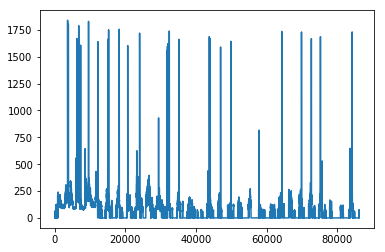

In [11]:
df.Power.plot()
plt.show()

In [12]:
print("Shape: ",df.shape)

Shape:  (86200, 2)


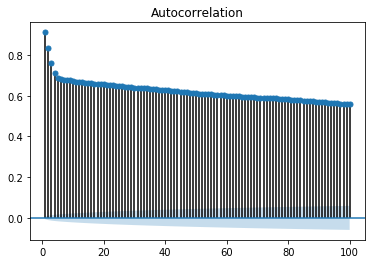

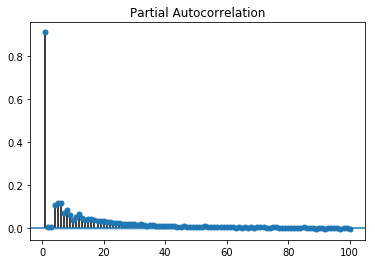

---


In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(df.Power, lags=100, zero=False)
plot_pacf(df.Power, lags=100, zero=False)
plt.show()
print("---")

In [23]:
#---- Hyperparams and settings ----

num_epochs = 6
batch_size = 200
learning_rate = 0.01
LSTM_SIZE = 300
random_seed = 12233344556 # For reproducibility, we keep this fixed



In [15]:
#---- Generate x and y from the raw DataFrame -----

# Use timestamp as index and later drop it as separate column - Pandas.DataFrame has index property
df = df.set_index(df.Timestamp)

# Generate y by shifting x one into the future
df["y"] = df.Power.shift(-1)

# As said, we don'"t need this as separate column
df.drop("Timestamp",axis=1, inplace=True)

# Nor do we need the last rows, where there might be no x or y (NaN) because of the shift
df.drop(df.head(1).index, inplace=True)
df.drop(df.tail(1).index, inplace=True)

# For nicety
df.rename(columns={'Power':'x'}, inplace=True)

# Just to be sure that we did what we wanted to do. This is good practice!
assert df.x.iloc[1] == df.y.iloc[0] 
assert not df.isnull().values.any()

# Use the power and sklearn.model_selection.train_test_split
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=random_seed, shuffle=False)

# For further reference
epoch_length = train_df.shape[0] // batch_size
valid_length = valid_df.shape[0] // batch_size

#Looks about right doesn't it?
print(train_df.shape)
print(valid_df.shape)


(77578, 2)
(8620, 2)


In [16]:
# Again magic, comes from the package Blaze, and especially Odo, as a data transformation library
# we love oneliners don't we? :-)
# See: http://blaze.pydata.org/
# And specifically: https://stackoverflow.com/questions/25699439/how-to-iterate-over-consecutive-chunks-of-pandas-dataframe-efficiently
# Goal: decompose the training_df into batch-size sized chunks
# WARN: only works with: conda install networkx=1.11 blaze odo USE STRCIT VERSION!!!
chunks =  bz.odo(train_df, target=bz.chunks(pd.DataFrame), chunksize=batch_size)

valid_chunks =  bz.odo(valid_df, target=bz.chunks(pd.DataFrame), chunksize=batch_size)


In [18]:
import itertools

# Another magic, comes from Python's Itertools
# see under: https://docs.python.org/3/library/itertools.html#itertools.cycle
# Goal: do an infinitely looping iterator over the chunks, 
# so one call with next(data_iterator) will yieald a minibatch
data_iterator = itertools.cycle(chunks)

valid_data_iterator = iter(valid_chunks)

In [24]:
%%time

# --- Graph definition ----

# First things first, clear all possible debris from TF
tf.reset_default_graph()
# Again for reproducibility reasons, set random seed
tf.set_random_seed(random_seed)


# Placeholders for feeding in one batch of data
x = tf.placeholder(tf.float32, [batch_size,1])
y = tf.placeholder(tf.float32, [batch_size,1])


# LSTM cell accepting the data as input
# there is a more elaborate LSTM implementation under https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell
# but we stick to the basics
lstm_cell = tf.contrib.rnn.BasicLSTMCell(LSTM_SIZE)

# Well, the thing itself
outputs, _ = tf.contrib.rnn.static_rnn(lstm_cell, tf.unstack(tf.expand_dims(x, 1), axis=0), dtype=tf.float32)

# Linear layer on top of LSTM output for prediction
weight = tf.Variable(tf.random_normal([LSTM_SIZE, 1]))
bias = tf.Variable(tf.random_normal([1]))
# Doing linear "layer", getting predictions
predictions = tf.matmul(tf.reshape(outputs,[batch_size,LSTM_SIZE]), weight) + bias

# Calculate loss. 
loss = tf.losses.mean_squared_error(y, predictions)

# We use Adamm for convenience, but please refer to the optimization class...
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# We need those variables to become really existent
init = tf.global_variables_initializer()

#--- Main training cycle ---

with tf.Session() as sess:
    
    # I mean REALLY! :-D
    sess.run(init)

    sum_train_loss=0
    
    # --- Training cycle ---
    for batch_num in range(num_epochs*epoch_length):
        
        # Get next batch of training data from the infinite iterator
        batch = next(data_iterator)
        
        if batch.x.shape[0]!= batch_size:
            #FIXME: implement zero paddign
            batch = next(data_iterator)
        
        # Run the training on the batch
        _, batch_loss = sess.run([optimizer, loss], feed_dict={x: np.expand_dims(batch.x.values, axis=1), y: np.expand_dims(batch.y.values, axis=1)})
        sum_train_loss += batch_loss
        
        # at approximate epoch end, integer mod 0
        if batch_num % epoch_length == 0:
            
            sum_valid_loss = 0
            full_valid_predictions = []
            
            for valid_batch in valid_data_iterator:
                if valid_batch.x.shape[0]==batch_size:
                    # Run the forward pass for one batch on the validation data
                    valid_loss, valid_predictions = sess.run([loss, predictions], feed_dict={x: np.expand_dims(valid_batch.x.values,axis=1), y: np.expand_dims(valid_batch.y.values, axis=1)})
                    # Collect the loss and predictions of that batch
                    sum_valid_loss += valid_loss
                    full_valid_predictions.extend(valid_predictions)
                else:
                    #Fixme: padding
                    # "Resetting" iterator to be used - there is no explicit reset in default itertools
                    valid_data_iterator = iter(valid_chunks)
            print("Epoch:", '%04d' % (batch_num // epoch_length), " full train loss =", "{:.3f}".format(sum_train_loss/epoch_length),  " summed valid cost =", "{:.3f}".format(sum_valid_loss/valid_length))
            #print("Epoch:", '%04d' % (batch_num // epoch_length), " full train loss (length normalized)=", "{:.3f}".format(sum_train_loss/train_df.shape[0]),  " summed valid cost (length normalized)=", "{:.3f}".format(sum_valid_loss/valid_df.shape[0]))
            sum_train_loss = 0
            
    print("Optimization Finished!")


Epoch: 0000  full train loss = 8.362  summed valid cost = 4666.559
Epoch: 0001  full train loss = 6813.941  summed valid cost = 2833.264
Epoch: 0002  full train loss = 5848.980  summed valid cost = 2302.487
Epoch: 0003  full train loss = 5060.577  summed valid cost = 2159.358
Epoch: 0004  full train loss = 4994.671  summed valid cost = 2312.817
Epoch: 0005  full train loss = 4901.423  summed valid cost = 2010.649
Optimization Finished!
CPU times: user 2min 32s, sys: 14.5 s, total: 2min 47s
Wall time: 2min 44s


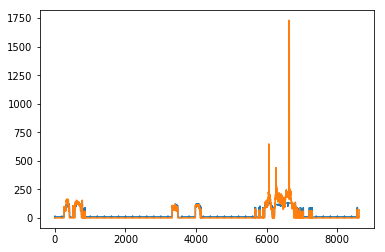

In [25]:
plt.plot(full_valid_predictions)
plt.plot(valid_df.y.values)
plt.show()


## How is this model to be improved?

In many ways this model is too basic, needs heavy improvement.

1. Data loader is not the most effective, is not good for GPU computation. Better use the new [Data API](https://www.tensorflow.org/api_docs/python/tf/data) of TensorFlow
2. Does not use regularization at all, Dropout should be added. The question is where to put it in RNNs, for this see [here](http://dx.doi.org/10.1109/ICDAR.2015.7333848) and [here](https://arxiv.org/abs/1512.05287)
3. Should use some data normalization, details can be found [here](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)
4. It does not solve the transfer of inner **states between minibatches** and on epoch begin (called "statefulness" and "warmup" respectively). Tips for **Warmup** [here](https://arxiv.org/pdf/1710.03222.pdf), for statefullness [here](https://stackoverflow.com/questions/38241410/tensorflow-remember-lstm-state-for-next-batch-stateful-lstm?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
5. It does not even use train-valid-test split, no validation at all!!! Tips can be found [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
6. Hyperparameters could be optimized manually or with search techniques
7. [Dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) model can be used from TensorFlow instead of the static one
8. Multiple LSTM layers can be stacked upon each-other
9. Even zero padding can be used not to drop batches at the end of epochs

As said, a really basic model...